In [1]:
from wedgescan_functions import get_slice_processed

from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.utilities.display import show2D, show_geometry
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import RingRemover, Padder, Slicer, TransmissionAbsorptionConverter, Normaliser, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP

import numpy as np
import matplotlib.pyplot as plt
import hdf5plugin
import h5py
import glob
import os
from tomopy.prep.phase import retrieve_phase

In [2]:
from scripts.HDF5_ParallelDataReader import HDF5_ParallelDataReader

##### Load the data

Specify the parent directory and list the scans

In [3]:
# specify the parent directory
parent_directory = '/mnt/data/ESRF/test_data/'

# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.h5'))
for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))


0: /mnt/data/ESRF/test_data/PC811_1000cycles_absct_final_0001.h5


Choose the scan

In [4]:
# choose the number of the file in the files list 
filename = files[0]

# or uncomment below to specify the filename directly
# filename = '/mnt/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'

Read the file metadata

In [5]:
HDF5_utilities.print_metadata(filename)

	 - 1.1 : <HDF5 group "/1.1" (6 members)>
		 - end_time : <HDF5 dataset "end_time": shape (), type "|O">
		 - instrument : <HDF5 group "/1.1/instrument" (37 members)>
			 - epoch_trig : <HDF5 group "/1.1/instrument/epoch_trig" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
						 - units : s
			 - fpico2 : <HDF5 group "/1.1/instrument/fpico2" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
			 - fpico3 : <HDF5 group "/1.1/instrument/fpico3" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
			 - fscan_parameters : <HDF5 group "/1.1/instrument/fscan_parameters" (24 members)>
				 - acq_time : <HDF5 dataset "acq_time": shape (), type "<f8">
				 - camera_signal : <HDF5 dataset "camera_signal": shape (), type "|O">
				 - display_flag : <HDF5 dataset "display_flag": shape (), type "|b1">
				 - fast_acc_margin : <HDF5 dataset "fast_acc_margin": shape (), type "<f8">
				 - fast_motor : <HDF5 dataset "fast_m

In [6]:
reader = HDF5_ParallelDataReader(filename, 
                                 dataset_path=('1.1/measurement/pcoedgehs/',
                                               '4.1/measurement/pcoedgehs/'),
                                 distance_units='mm', angle_units='degree')

reader.configure_angles(angles_path=('1.1/measurement/hrrz_center',
                        '4.1/measurement/hrrz_center'))

reader.configure_pixel_sizes('1.1/instrument/pcoedgehs/x_pixel_size',
                             '1.1/instrument/pcoedgehs/y_pixel_size', HDF5_units = 'um')

reader.configure_normalisation_data(flatfield_path='2.1/measurement/pcoedgehs/',
                                    darkfield_path='3.1/measurement/pcoedgehs/')

reader.configure_sample_detector_distance(sample_detector_distance=90, HDF5_units='mm')

data = reader.read()

In [7]:
reader.metadata

{'pixel_size_x': 0.006500000000000001,
 'pixel_size_y': 0.006500000000000001,
 'sample_detector_distance': 90.0,
 'distance_units': 'mm',
 'angle_units': 'degree',
 'angles': array([5.95043302e-02, 1.79463148e-01, 2.99481362e-01, ...,
        3.71760193e+02, 3.71880127e+02, 3.72000092e+02])}

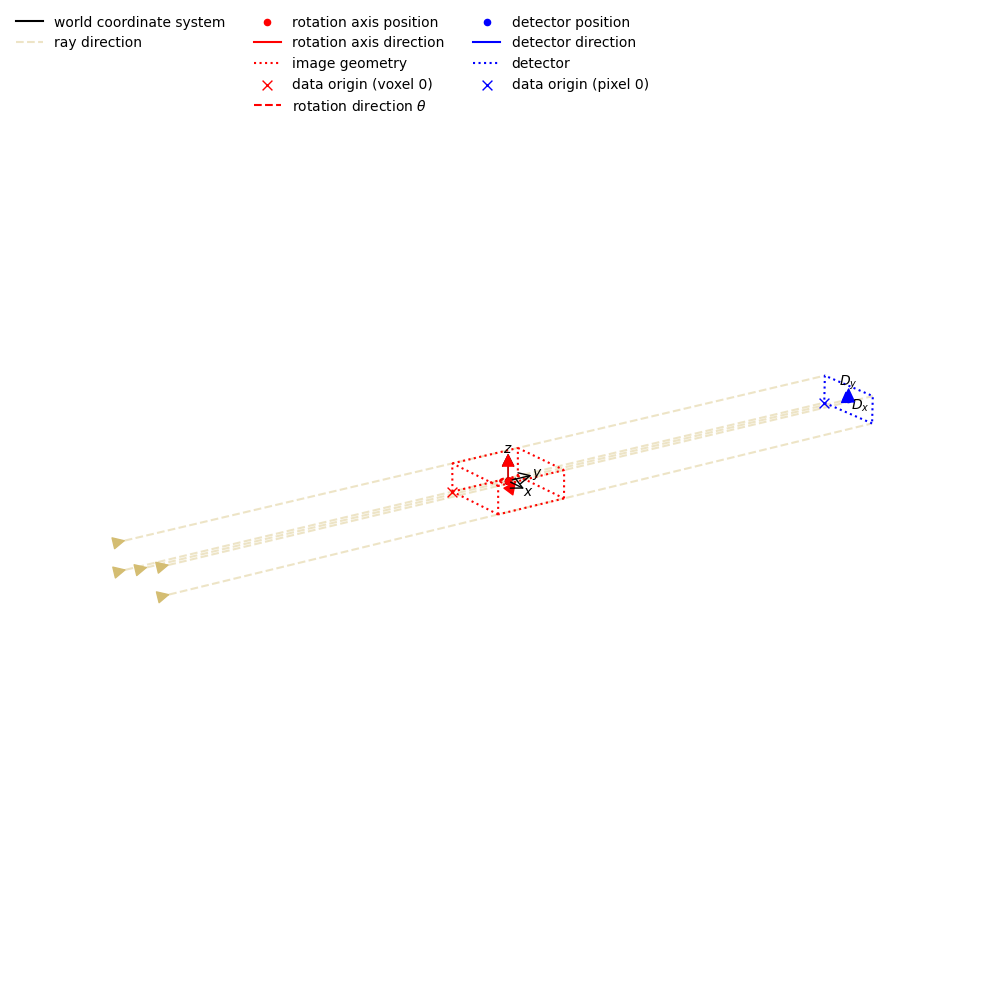

In [8]:
show_geometry(data.geometry)

##### Normalise

In [9]:
processor = Normaliser(flat_field=np.mean(reader.flatfield, axis = 0), dark_field=np.mean(reader.darkfield, axis = 0))
processor.set_input(data)
data_out = processor.get_output()

In [10]:
beam_current = HDF5_utilities.read(filename, '4.1/instrument/machine/current/')
beam_current

array(31.675932, dtype=float32)

##### Pre-processing

Get a slice

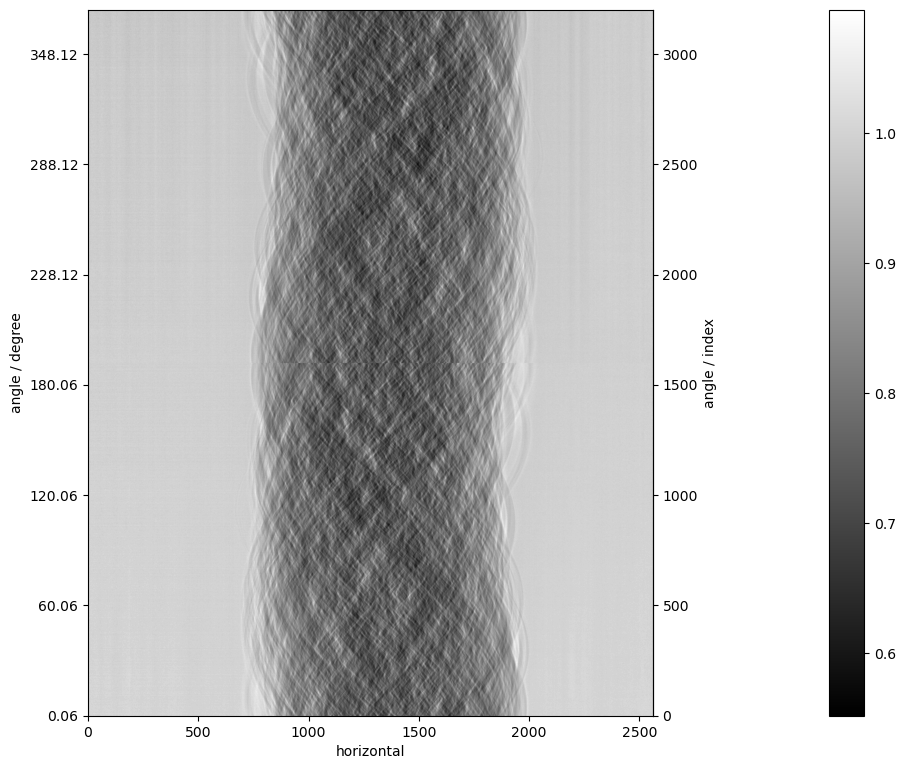

In [11]:
vertical_slice = 400
data_slice = data_out.get_slice(vertical=vertical_slice)
show2D(data_slice)

Run the CIL transmission to absorption processor 

If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

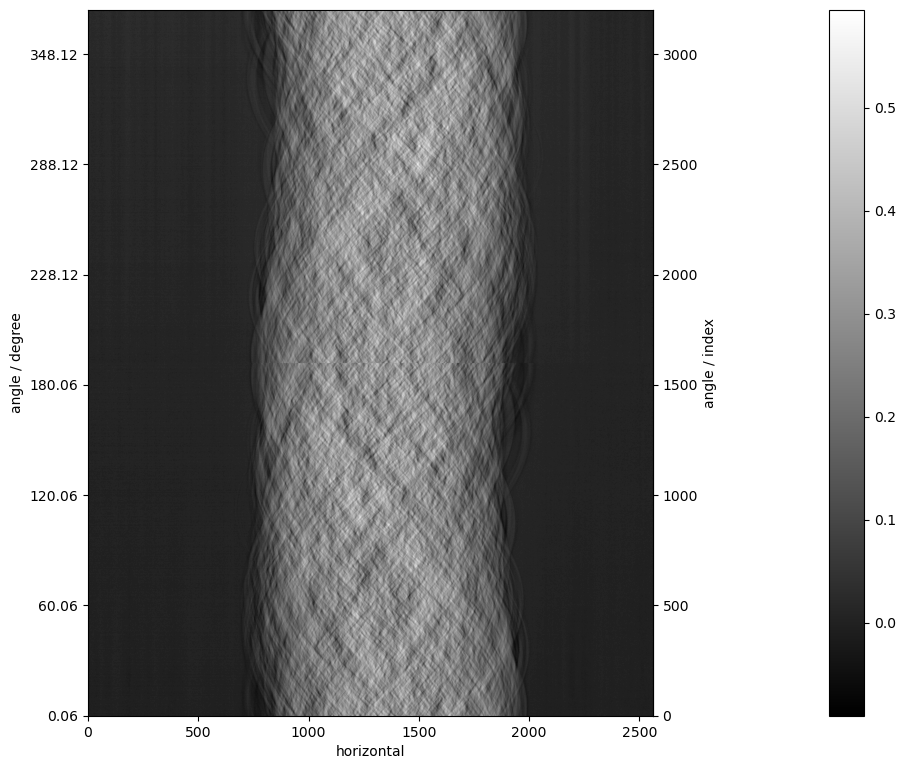

In [12]:
processor = TransmissionAbsorptionConverter(min_intensity=0.001)
processor.set_input(data_slice)
processor.get_output(out=data_slice)
show2D(data_slice)

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, uncomment this cell to use the CIL `CentreOfRotationCorrector.xcorrelation` processor to find the centre of rotation offset automatically
- Specify a first projection to use for the correlation, and the algorithm will identify the second angle which is 180 degrees from the first - within a specified angular tolerance 

In [ ]:
processor = CentreOfRotationCorrector.xcorrelation()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

print(data.geometry)

In [ ]:
reco = FBP(data_slice).run()
show2D(reco)

Alternatively manually enter a pixel offset. This could be extracted from the dataset metadata as a starting point

In [ ]:
# offset_rotation = HDF5_utilities.read(filename, '/4.1/instrument/positioners/yrot')
# print(offset_rotation)

# x_pixel_size = HDF5_utilities.read(filename, '/4.1/instrument/pco2linux/x_pixel_size')
# print(x_pixel_size)

# pixel_offset = offset_rotation/x_pixel_size

Adjust the offset until the rotation artefacts are minimised

In [ ]:
pixel_offset = 83.78
data_tmp = data_slice.copy()
data_tmp.geometry.set_centre_of_rotation(pixel_offset, distance_units='pixels')

reco = FBP(data_tmp).run()
show2D(reco)

Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing the number of decompositions increases the frequency of ring artefacts that can be removed
- Increasing sigma will increase the strength of the ring remover, but too high sigma will distort the profile of the image

Phase

In [ ]:
from cil.processors import PaganinProcessor

processor = PaganinProcessor(delta=1, beta=0.002, energy=40000, full_retrieval=False)
processor.set_input(data_slice)
data_tmp = processor.get_output()
show2D([data_slice, data_tmp])
reco_phase = FBP(data_tmp, backend='astra').run(verbose=0)
reco_phase.apply_circular_mask(0.9)

show2D([reco.array[1000:1200,1000:1200], reco_phase.array[1000:1200,1000:1200]])

In [ ]:
from tomopy.prep.phase import retrieve_phase

In [45]:
tomopy_alpha = (1/(1/0.002))/(4*np.pi**2)
data_tmp = retrieve_phase(data.array, pixel_size=processor.pixel_size, dist=processor.propagation_distance, energy=40000/1000, alpha=tomopy_alpha)

In [ ]:
processor.pixel_size

In [46]:
data_tomopy = data.copy()
data_tomopy.fill(data_tmp)

In [47]:
data_slice_tomopy = data.get_slice(vertical=vertical_slice)
reco_phase_tomopy = FBP(data_slice_tomopy, backend='astra').run(verbose=0)
reco_phase_tomopy.apply_circular_mask(0.9)

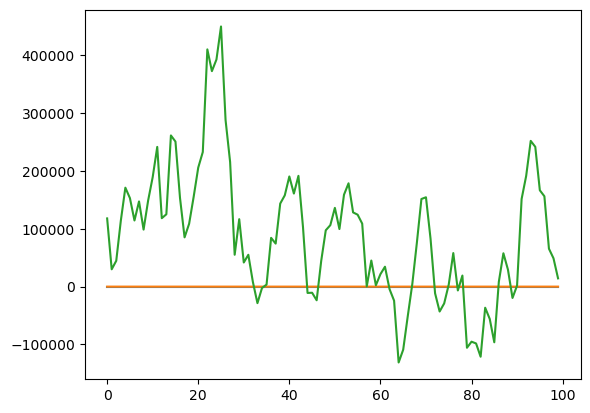

: 

In [48]:
plt.plot(reco.array[1100,1100:1200])
plt.plot(reco_phase.array[1100,1100:1200]*100)
plt.plot(reco_phase_tomopy.array[1100,1100:1200]*100)

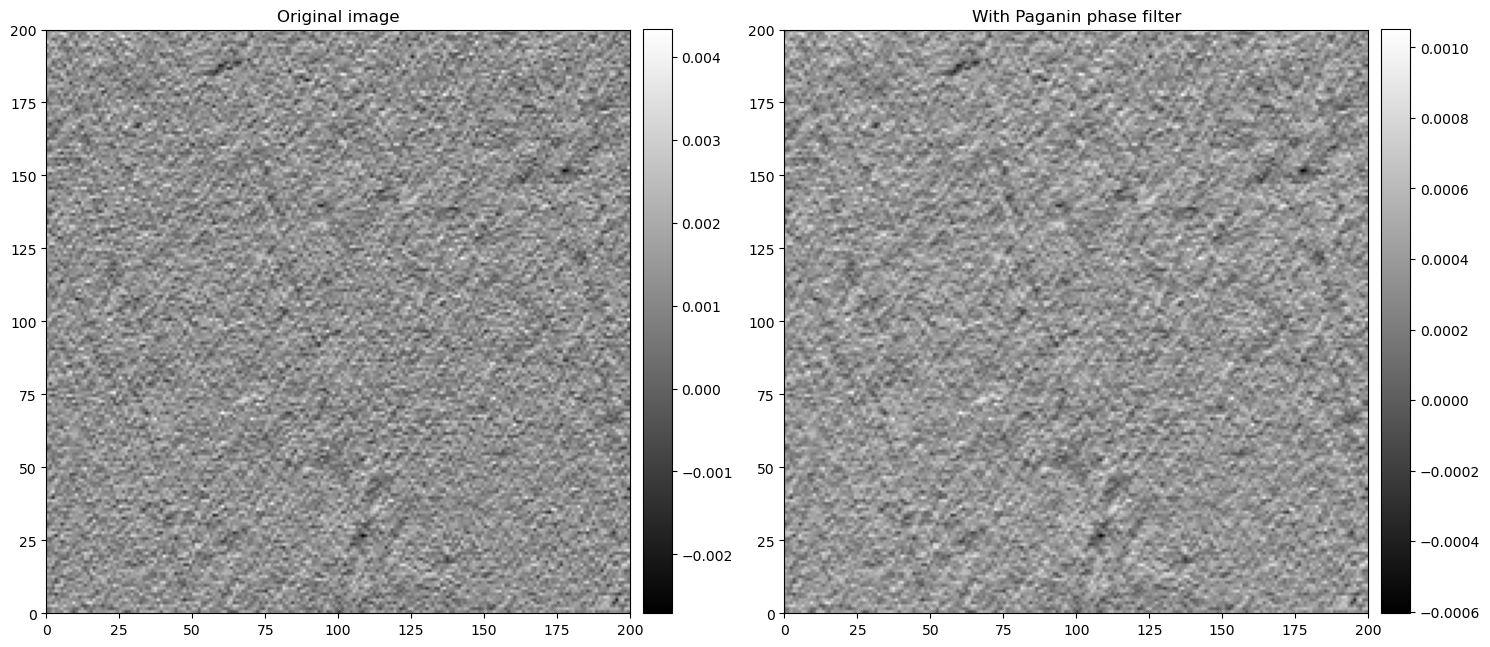

In [ ]:
show2D([recon.array[1000:1200,1000:1200], recon_phase.array[1000:1200,1000:1200]],
       title=['Original image', 'With Paganin phase filter'])

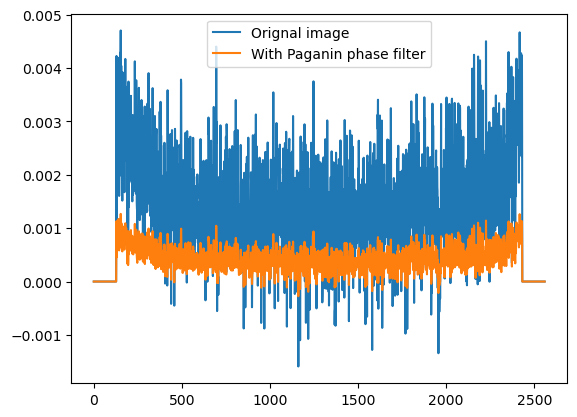

In [ ]:
plt.plot(recon.array[1250,:])
plt.plot(recon_phase.array[1250,:])
plt.legend(['Orignal image','With Paganin phase filter'])

consider using filter_type = 'generalised_paganin_method'
100%|██████████| 3000/3000 [00:00<00:00, 3078.83it/s]


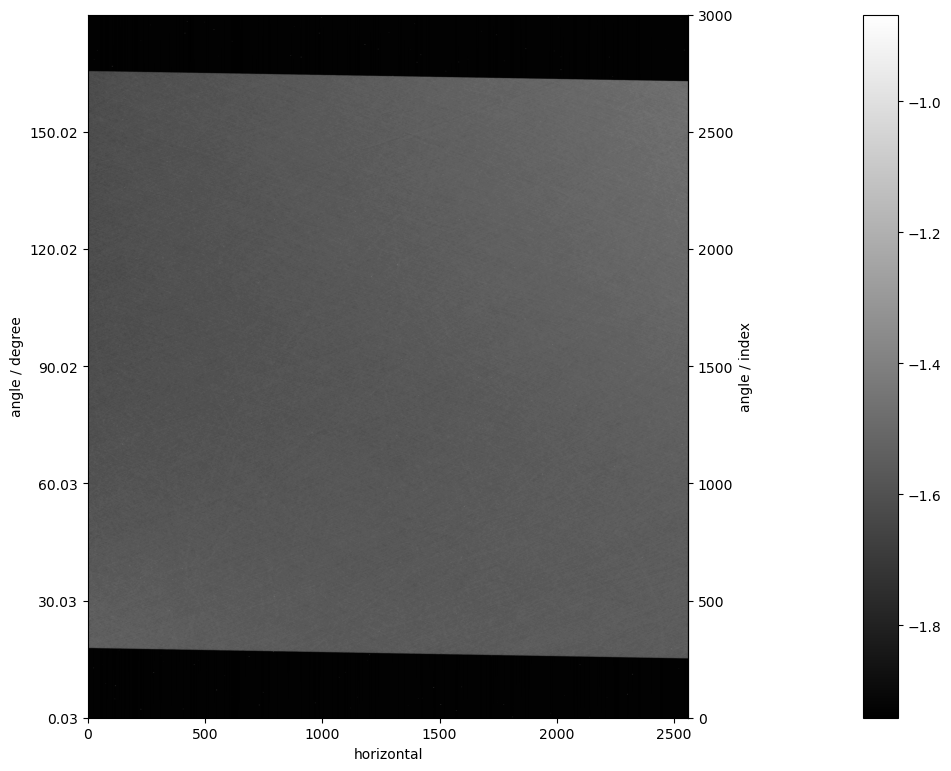

In [ ]:
from cil.processors import PhaseRetriever
processor = PhaseRetriever.Paganin(propagation_distance=1)
processor.set_input(data_slice)
data_tmp = processor.get_output(output_type='attenuation')
show2D(data_tmp)

In [ ]:
data_slice.geometry.magnification

1.0

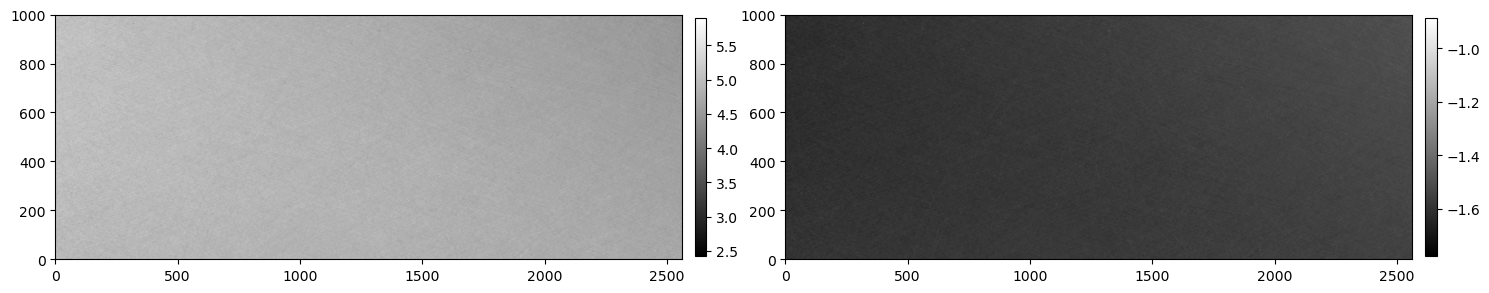

In [ ]:
show2D([data_slice.array[1000:2000,:], data_tmp.array[1000:2000,:]])

In [ ]:
a = data_slice.get_slice(angle=0).as_array()
a.shape

(2560,)

##### Missing angles

If there are fully empty angles in the data, leaving them in is ok but if they are partially empty, leaving them in can introduce artefacts. Either remove the partially empty projections or pad them so the partial data isn't discarded

Find empty regions
- This cell will find the start and end point of the real data
- Tune the diff parameter to vary the extent of the difference between the empty regions and the data

In [ ]:
diff = 0.75

if 'vertical' not in data.dimension_labels:
    data_tmp = np.expand_dims(data.array, axis=0)
    v_slices = 1
     
else:
    data_tmp = data.array
    v_slices = data.get_dimension_size('vertical')

h_slices = data.get_dimension_size('horizontal')

start_fit = np.zeros([v_slices, h_slices])
end_fit = np.zeros([v_slices, h_slices])

for v in np.arange(v_slices):
    start_array = np.zeros(h_slices)
    end_array = np.zeros(h_slices)
    for h in np.arange(h_slices):
        index = np.where(abs(np.diff(data.get_slice(horizontal = h, force=True).array)) > diff)[0]
        start_array[h] = index[0]
        end_array[h] = index[-1]
    poly1d_fn = np.poly1d(np.polyfit(np.arange(h_slices), start_array,1))
    start_fit[v] = np.round(poly1d_fn(np.arange(h_slices))).astype(int)
    poly1d_fn = np.poly1d(np.polyfit(np.arange(h_slices), end_array,1)) 
    end_fit[v] = np.round(poly1d_fn(np.arange(h_slices))).astype(int)

Plot one slice and the fit indicating the start and end of the empty region (if you're running on multiple slices you might want to check more than one)

Text(0, 0.5, 'Projections')

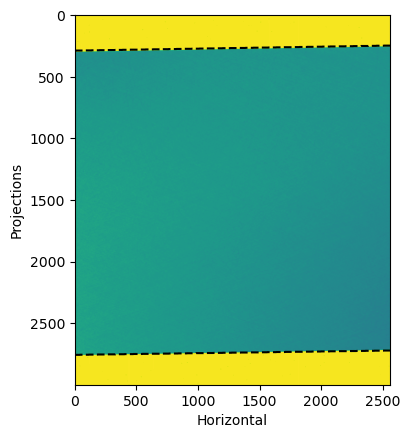

In [ ]:
slice_to_plot = np.floor(v_slices/2).astype(int)
plt.imshow(np.take(data_tmp, indices=slice_to_plot, axis=0))
plt.plot(start_fit[slice_to_plot], '--k')
plt.plot(end_fit[slice_to_plot], '--k')
plt.xlabel('Horizontal')
plt.ylabel('Projections')

To delete the empty angles including projections with any missing data, uncomment the following cell

In [ ]:
# buffer = 10
# lower_limit = np.max(start_fit).astype(int)+buffer
# upper_limit = np.min(end_fit).astype(int)-buffer
# data = Slicer(roi={'angle': slice(lower_limit, upper_limit)})(data)
# show2D(data)

To pad the partially empty regions, fill the partially empty projections with a local mean, then ramp to the mean of the whole sinogram
- Tune the `ramp_width` to give a smooth transition from the empty projections to the data
- Tune the `buffer` spacing to prevent any sharp changes between the data and the ramp

In [ ]:
ramp_width = 50
buffer = 13

for v in np.arange(v_slices):
    lower_limit = np.min(start_fit[v]).astype(int)
    upper_limit = np.max(end_fit[v]).astype(int)

    sino_mean = np.mean(data_tmp[v, lower_limit:upper_limit, :])

    for h in np.arange(h_slices):

        start = int(start_fit[v,h] + buffer)
        end = int(end_fit[v,h] - buffer)

        data_tmp[v, lower_limit:start, h] = np.mean(data_tmp[v, start:start+100, h])
        y_new = np.interp(np.arange(lower_limit-ramp_width,lower_limit), [lower_limit-ramp_width,lower_limit], [sino_mean, data_tmp[v, lower_limit,h]])
        data_tmp[v, lower_limit-ramp_width:lower_limit, h] = y_new
        data_tmp[v, 0:lower_limit-ramp_width, h] = sino_mean

        data_tmp[v, end:upper_limit, h] = np.mean(data_tmp[v, end-100:end, h])
        y_new = np.interp(np.arange(upper_limit-1,upper_limit+ramp_width-1), [upper_limit-1, upper_limit+ramp_width-1], [data_tmp[v, upper_limit-1, h], sino_mean])
        data_tmp[v, upper_limit-1:upper_limit+ramp_width-1, h] = y_new
        data_tmp[v, upper_limit+ramp_width-1:, h] = sino_mean

    # uncomment these lines to show all the line profiles of the padded sections
    #     plt.plot(data_tmp[v,:,h])
    # plt.xlabel('Projections')
    # plt.ylabel('Intensity')
  

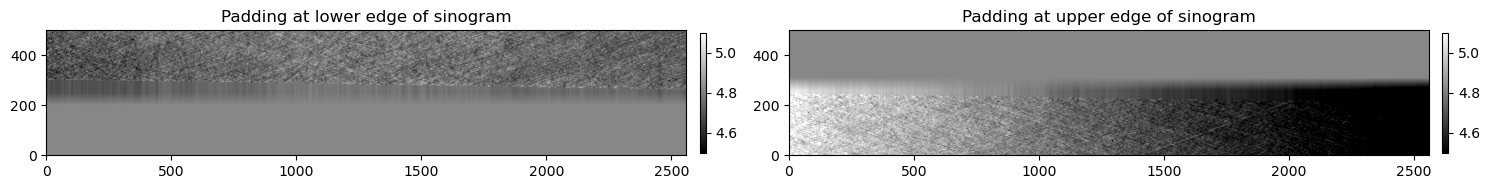

In [ ]:
slice_to_plot = 0
show2D([data_tmp[slice_to_plot,0:500,:],data_tmp[slice_to_plot, 2500:3000,:]], ['Padding at lower edge of sinogram','Padding at upper edge of sinogram'], fix_range=(4.5,5.1))

Put the data back in the AcquisitionData object

In [ ]:
data.fill(np.squeeze(data_tmp))

Check the effect on the reconstruction

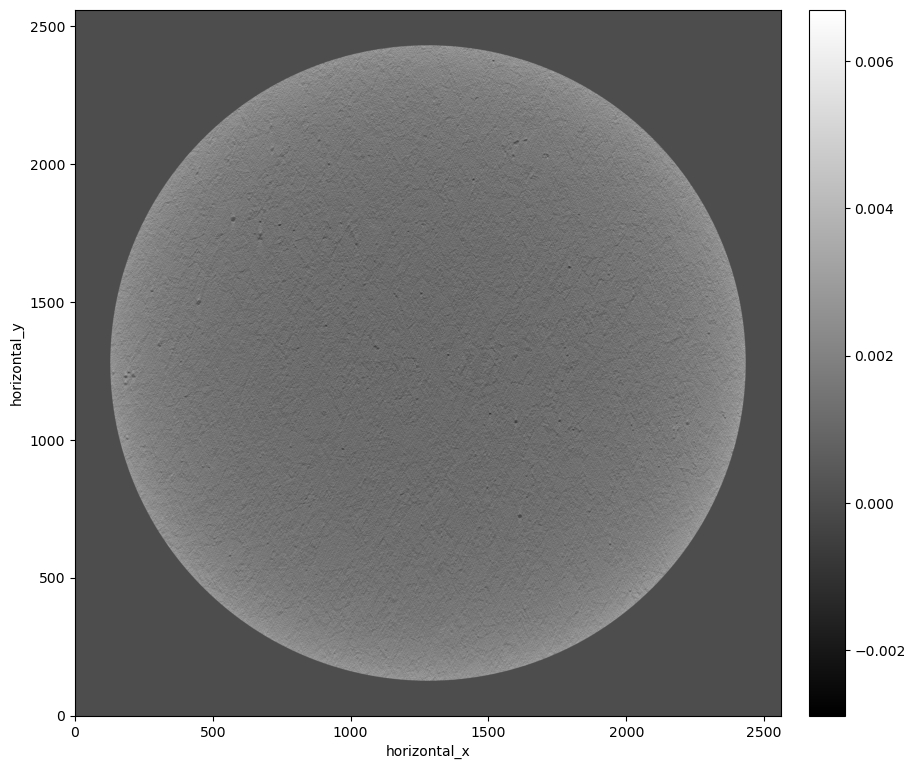

In [ ]:
recon = FBP(data, backend='astra').run(verbose=0)
recon.apply_circular_mask(0.9)
show2D(recon)

##### Gradient correction

Check if there is a gradient across the image by plotting a horizontal line plot for all projections and plot the mean gradient. If you have multiple vertical slices, plot the central one 



Text(0, 0.5, 'Intensity')

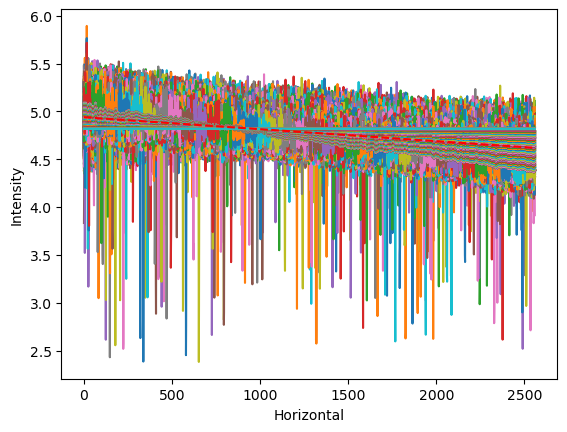

In [ ]:
a_slices = data.get_dimension_size('angle')

gradient = 0
offset = 0
mean_intensity = 0
for a in np.arange(a_slices):
        if 'vertical' in data.dimension_labels:
                y = data.array[int(data.shape[0]/2), a, :]
                mean_intensity += np.mean(data.array[:,a,:])
        else:
                y = data.array[a, :]
                mean_intensity += np.mean(data.array[a,:])
        x = np.arange(len(y))
        plt.plot(x,y)
        coef = np.polyfit(x,y,1)
        gradient += coef[0]
        offset += coef[1]
        
        poly1d_fn = np.poly1d(coef)

gradient = gradient/a_slices
offset = offset/a_slices
mean_intensity = mean_intensity/a_slices
poly1d_fn = np.poly1d([gradient, offset])
plt.plot(x, poly1d_fn(x), '--r')
plt.xlabel('Horizontal')
plt.ylabel('Intensity')

In [ ]:
mean_intensity

4.779103117465973

Correct the gradient and plot the corrected slices

Text(0, 0.5, 'Intensity')

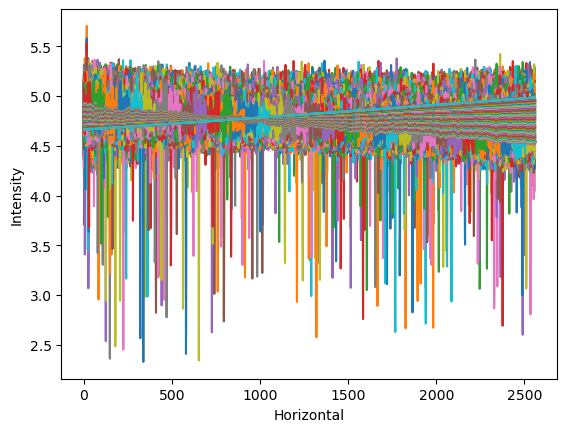

In [ ]:
for a in np.arange(a_slices):
    if 'vertical' in data.dimension_labels:
        data.array[:,a,:] = data.array[:,a,:] / poly1d_fn(x)
    else:
        data.array[a,:] = data.array[a,:] / poly1d_fn(x)
        
data.array = mean_intensity*data.array/np.mean(data.array)

for a in np.arange(a_slices):
    if 'vertical' in data.dimension_labels:
        plt.plot(data.array[:,a,:])
    else:
        plt.plot(data.array[a,:])

plt.xlabel('Horizontal')
plt.ylabel('Intensity')

Check the effect on the reconstruction

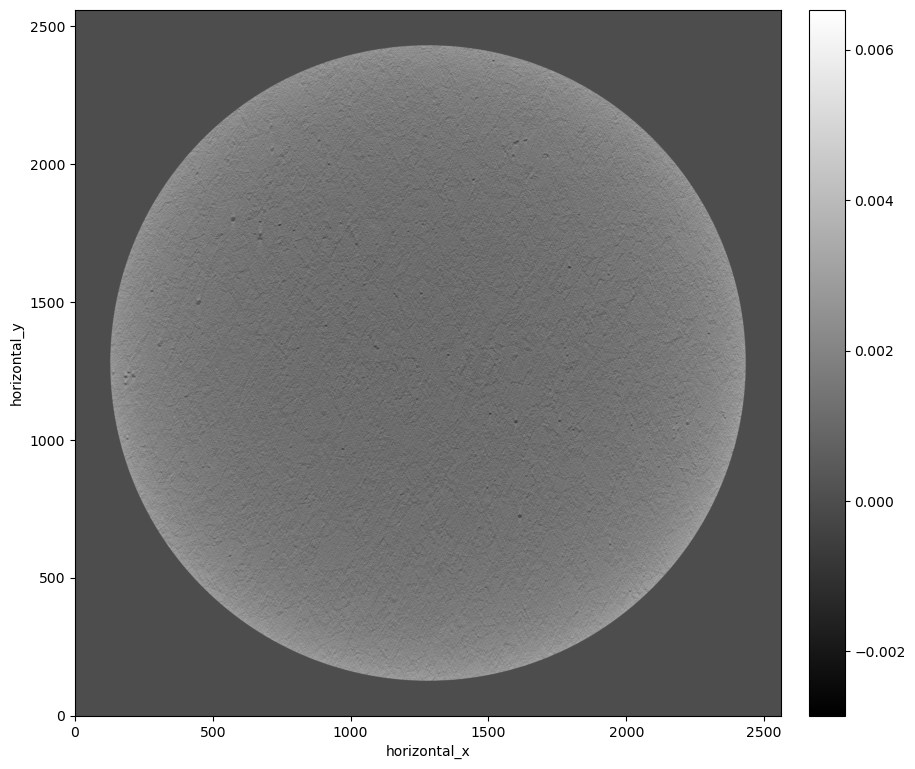

In [ ]:
recon = FBP(data, backend='astra').run(verbose=0)
recon.apply_circular_mask(0.9)
show2D(recon)

##### Phase retrieval

Use tomopy phase retrieval to filter the image
- Decrease the `alpha` parameter to increase the 'strength' of the phase retrieval
- Increased strength of the phase retrieval will improve signal to noise but blur edges

In [ ]:
if 'vertical' not in data.dimension_labels:
    data_tmp = np.expand_dims(data.array, axis=0)     
else:
    data_tmp = data.array
data_tmp = retrieve_phase(data_tmp, alpha=0.01)

Check the effect on the reconstruction

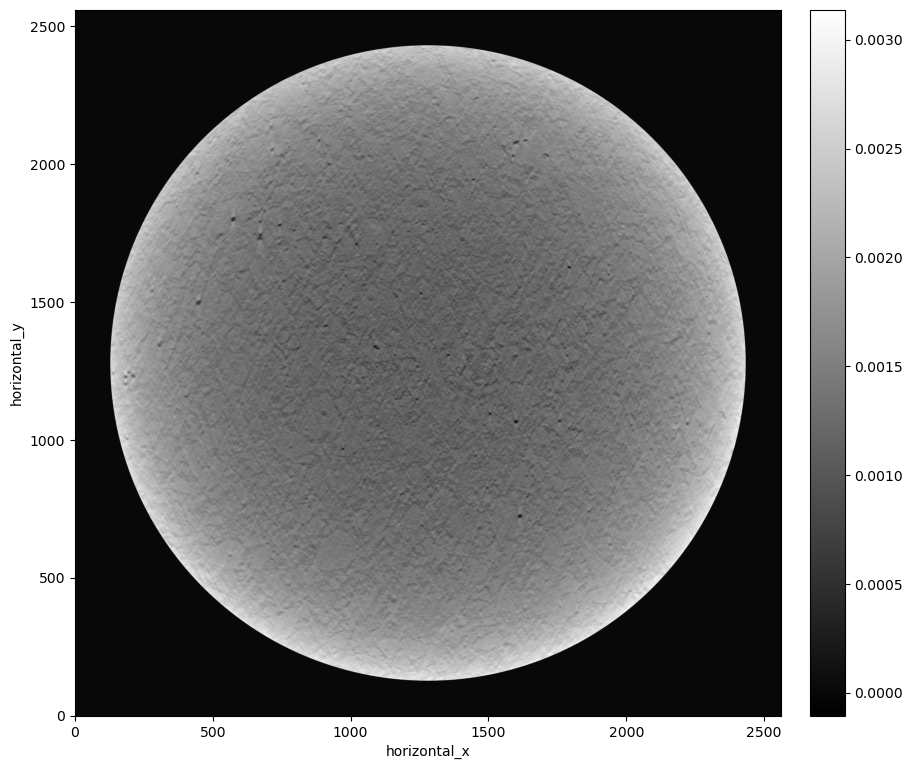

In [ ]:
data_tmp = AcquisitionData(np.squeeze(data_tmp), deep_copy=False, geometry = data.geometry)
recon = FBP(data_tmp, backend='astra').run(verbose=0)
recon.apply_circular_mask(0.9)
show2D([recon])

Once you're happy with the phase retrieval, save the corrected data

In [ ]:
data = data_tmp.copy()

##### Pad horizontal

If the data is a region of interest scan, the missing data can cause a gradient across the reconstruction. Padding in the horizontal axis may help to reduce this effect

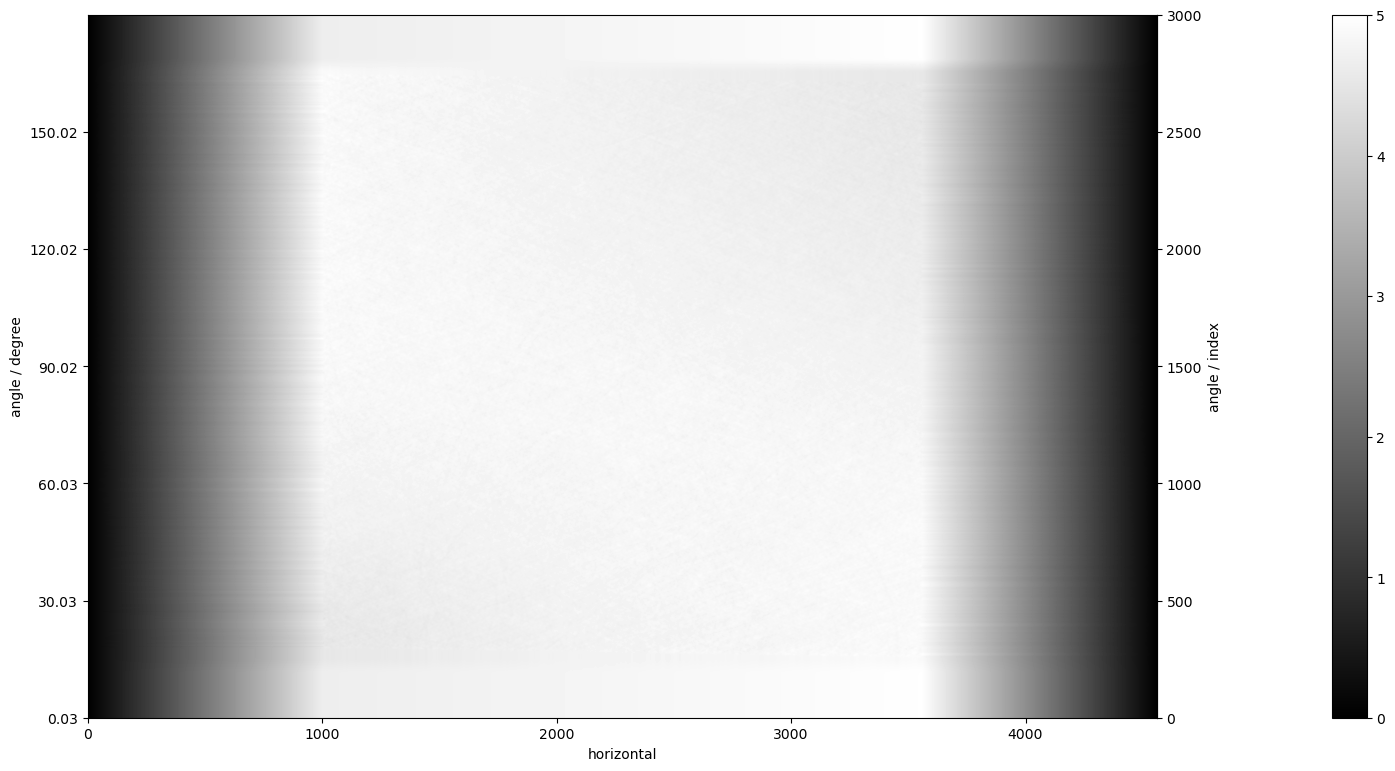

In [ ]:
ig = data.geometry.get_ImageGeometry()
padsize = 1000
data = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data)
show2D(data, slice_list=('vertical', 0)) 

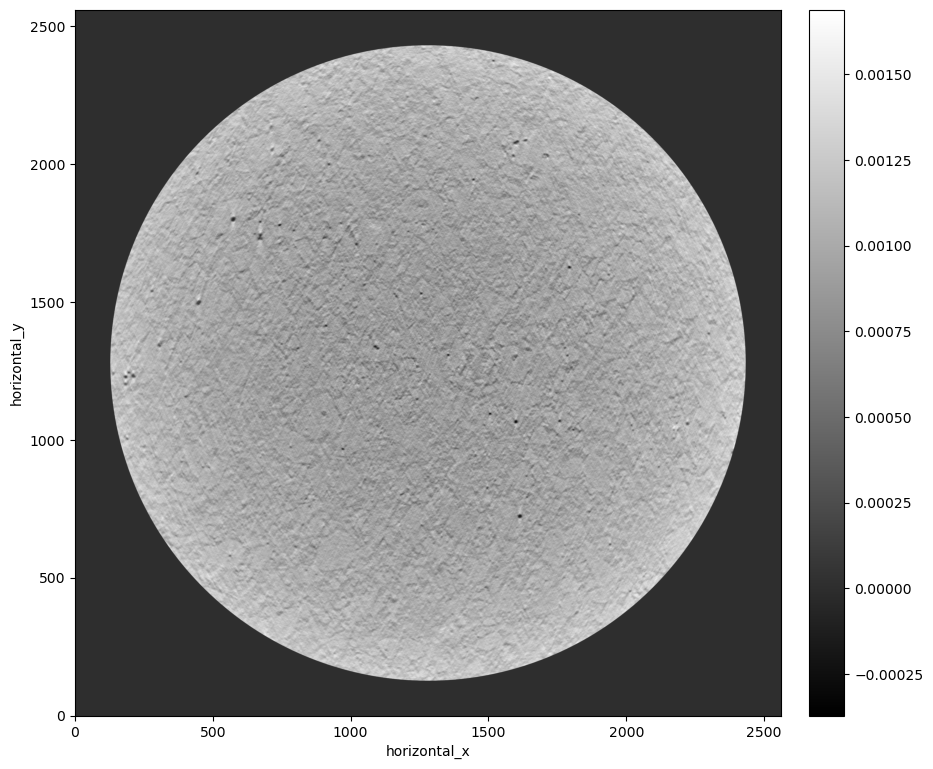

In [ ]:
ig_pad = data.geometry.get_ImageGeometry()
recon = FBP(data, ig, backend='astra').run(verbose=0)
recon.apply_circular_mask(0.9)
show2D([recon])

##### Save the processed data

Save the processed data as TIFF

In [ ]:
writer = TIFFWriter()
writer.set_up(data = data, file_name='path_to_data/data.tiff') #add data type, cast to float16
writer.write()